In [57]:
import pandas as pd

import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [58]:
model = models.resnet18(pretrained=True)
model = model.eval()

C:\Users\OEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\OEM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [59]:
df = example_data = pd.read_csv("kaggle/input/deep-learning-for-msc-2022-23/train.csv")

idx_to_labels = df['Label']

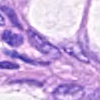

In [60]:
img = Image.open(r'kaggle\input\deep-learning-for-msc-2022-23\train\1.png')

img

In [61]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)

input = input.unsqueeze(0)


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [ ]:
output = model(input)

output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()

predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


tensor([[-6.2746e-01, -5.0925e-02,  5.2677e-01,  9.6142e-01,  8.8568e-02,
          3.5894e+00,  6.1705e-01,  3.2592e-02,  5.5386e-01,  5.2923e-01,
          2.6632e+00, -1.3947e-01, -2.7363e-01,  6.4669e-01,  6.0570e-01,
          2.3908e+00,  8.0085e-01,  1.3925e+00,  9.0743e-01,  6.5462e-01,
          2.9558e+00,  7.3876e-01,  1.4846e-01,  3.7626e-01,  1.1491e+00,
          3.9634e-01,  3.9194e+00,  2.7110e+00,  1.5947e+00,  1.1764e+00,
          9.2673e-01,  1.5970e+00,  2.9985e+00,  9.6306e-01,  1.6501e+00,
          9.2199e-01,  1.6415e+00,  5.4054e-01,  2.5834e+00,  2.6553e-01,
          2.1508e+00,  2.9227e+00,  2.4347e+00,  2.6861e+00,  1.8176e+00,
          4.8863e-01,  6.6375e-01,  2.5063e+00,  5.5758e-01,  9.5237e-01,
          1.2842e-02,  2.2049e+00,  2.4870e+00,  7.5906e-01,  9.0955e-01,
          2.9950e-03, -4.8950e-01, -2.0975e-01,  1.5625e+00,  2.8089e+00,
          1.8486e+00,  2.0962e-01,  1.4353e+00,  2.3635e+00,  1.8005e+00,
          2.0416e+00,  3.7965e+00,  4.

In [63]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)



Predicted: 0 ( 0.17813339829444885 )


# Why is there no other image?

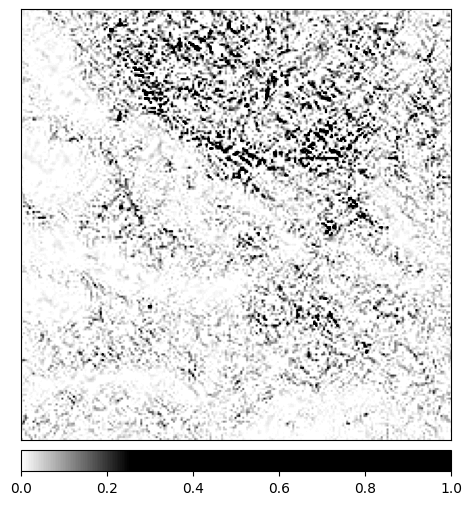

In [64]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


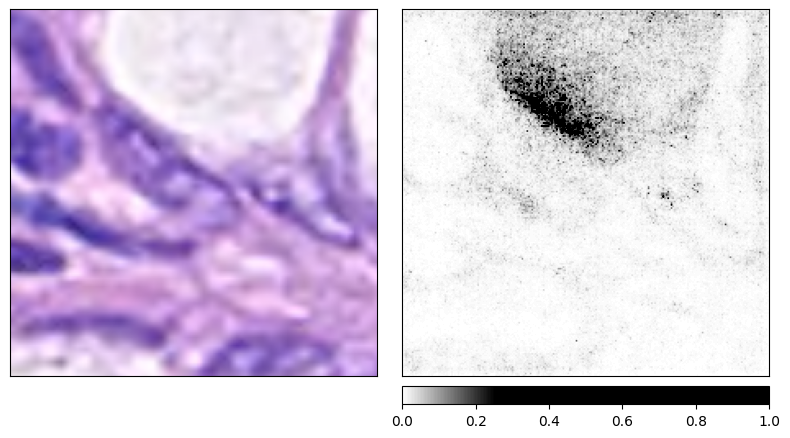

In [65]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

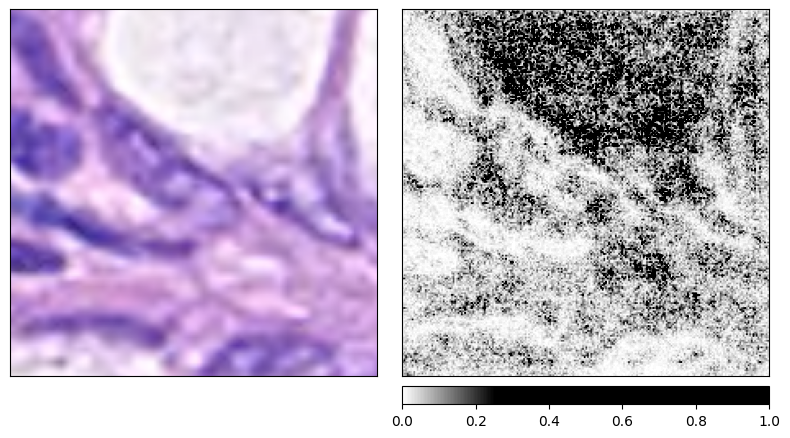

In [66]:


gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


In [67]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

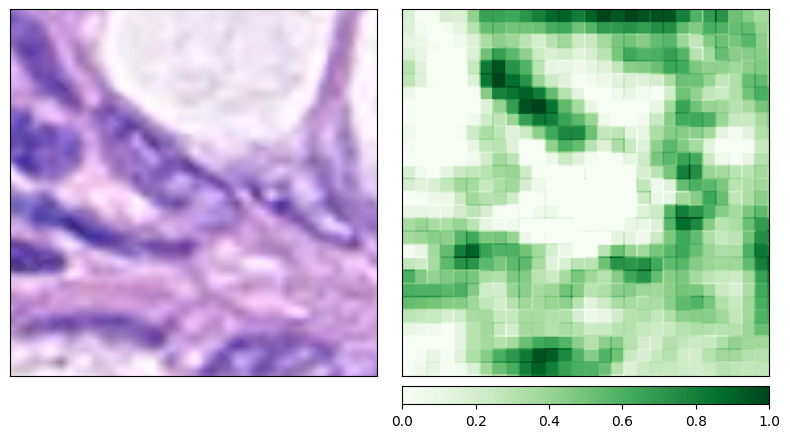

In [68]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

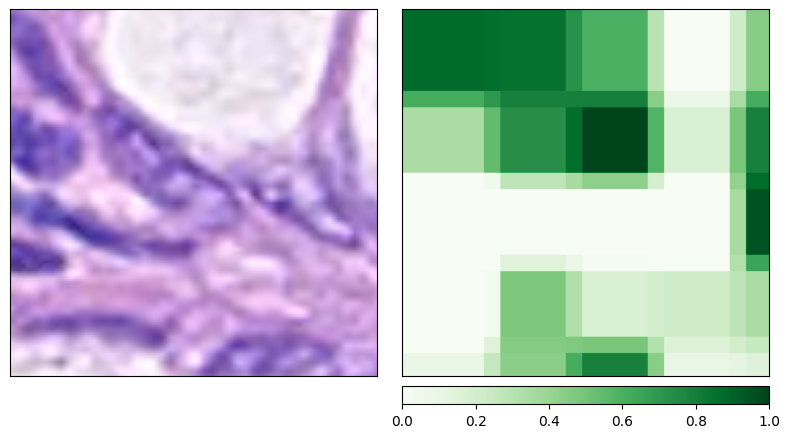

In [69]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )